**сиамская сеть, оцениваем схожесть текстов**

Евгений Борисов <esborisov@sevsu.ru>

## Библиотеки

In [1]:
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm import tqdm
# import gzip
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_colwidth = 200  
tqdm.pandas()

def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [3]:
# каталог товаров
data = pd.read_excel('../data/okpd2.xlsx')
ppr(data)
data.sample(3)

записей: 19 464


,Код,Наименование,Комментарий
3874,23.14.99,"Услуги по производству стекловолокна отдельные, выполняемые субподрядчиком",NaN
6306,01.22.14.000,Инжир,NaN
4981,45.11.31,Услуги по розничной торговле легковыми автомобилями и грузовыми автомобилями малой грузоподъемности через информационно-коммуникационную сеть Интернет,NaN


In [4]:
# нумеруем позиции каталога
data['id'] = range(len(data))
# будем использовать второй уровень каталога (две первые цифры)
data['group'] = data['Код'].str[:5]

In [5]:
# длина описаний в символах
data['Наименование'].str.len().describe([.95]).astype(int)

count    19464
mean        58
std         39
min          3
50%         50
95%        130
max        540
Name: Наименование, dtype: int64

In [6]:
# выкидываем короткие описания и дубликаты
data = data[ (data['group'].str.len()==5) & data['Наименование'].str.len().between(30,100) ]\
  .drop_duplicates(['Наименование'])[['id','group','Наименование']]\
  .reset_index(drop=True)

ppr(data)
data.sample(3)

записей: 9 632


,id,group,Наименование
2592,5553,64.19,Услуги по предоставлению кредитов финансовыми организациями прочие
6423,12742,24.45,"Магний и изделия из него, сплавы на основе магния, порошки"
9410,19192,95.23,"Услуги по укреплению подошв, каблуков, крокульной части подошв"


In [7]:
# формируем списки описаний по группам
groups =  data[['id','group']].groupby('group')['id'].apply(list).reset_index()
ppr(groups)

записей: 596


In [8]:
# количество описаний в группах
groups['id'].str.len().describe([.95]).astype(int)

count    596
mean      16
std       24
min        1
50%        7
95%       62
max      185
Name: id, dtype: int64

In [9]:
# выкидываем группы с малым количеством описаний, обрезаем большие списки
n_samples = 10

ppr(groups)
groups = groups[ groups['id'].str.len()> n_samples ].reset_index(drop=True)
ppr(groups)
groups['id'] = groups['id'].apply(rng.permutation).str[:n_samples]

записей: 596
записей: 227


In [10]:
# похожие примеры
groups['id_eq'] = groups['id'].apply(rng.permutation)

In [11]:
groups

,group,id,id_eq
0,01.11,"[6153, 2827, 6143, 6164, 6118, 1368, 1364, 6061, 2847, 18522]","[6153, 6118, 6061, 18522, 6143, 1364, 2847, 6164, 1368, 2827]"
1,01.13,"[6235, 6229, 2874, 6238, 1379, 1373, 6225, 6230, 6222, 744]","[6225, 744, 6238, 6235, 6230, 1373, 6229, 1379, 6222, 2874]"
2,01.15,"[18165, 18168, 6245, 18175, 18169, 18177, 18178, 6246, 18171, 18164]","[18169, 18175, 18178, 6245, 18165, 18171, 18177, 6246, 18168, 18164]"
3,01.16,"[2887, 6249, 6272, 6264, 6270, 6250, 6259, 6258, 6271, 747]","[6264, 6259, 747, 6272, 2887, 6249, 6258, 6271, 6250, 6270]"
4,01.19,"[6273, 6295, 6283, 2893, 6289, 6298, 1385, 6288, 2894, 6284]","[2893, 6289, 6295, 1385, 6288, 6283, 6273, 6298, 6284, 2894]"
...,...,...,...
222,95.29,"[19261, 19274, 19284, 19279, 19304, 19320, 19321, 19281, 19282, 19297]","[19321, 19297, 19282, 19261, 19281, 19304, 19320, 19284, 19279, 19274]"
223,96.01,"[19332, 19403, 19371, 19372, 19379, 19355, 19323, 19338, 19393, 19329]","[19323, 19329, 19371, 19332, 19403, 19372, 19393, 19338, 19379, 19355]"
224,96.02,"[19414, 6025, 1353, 2817, 19415, 19411, 19412, 6026, 2818, 19410]","[19415, 2817, 19410, 6026, 19411, 1353, 19414, 2818, 19412, 6025]"
225,96.03,"[1354, 19427, 19430, 19424, 19438, 19431, 19432, 19434, 19439, 6030]","[19438, 1354, 6030, 19427, 19424, 19432, 19430, 19431, 19439, 19434]"


In [12]:
# непохожие примеры

# пары из разных групп
groups_ = groups[['group']].reset_index(drop=True)
groups_['group_neq'] = rng.permutation(groups['group'])
groups_ = groups_.query('group!=group_neq')

groups_ = groups_.merge( groups[['group','id']]\
                          .rename(columns={'group':'group_neq','id':'id_neq'}), 
                        on=['group_neq'])

groups_['id_neq'] = groups_['id_neq'].apply(rng.permutation)

# groups[['group','id']].rename(columns={'group':'group_neq','id':'id_neq'})

groups_

,group,group_neq,id_neq
0,01.11,95.24,"[19216, 19226, 19225, 19228, 19221, 19217, 1349, 19229, 19219, 19222]"
1,01.13,10.13,"[7927, 18244, 18216, 18221, 7895, 18312, 18311, 18326, 18313, 18269]"
2,01.15,10.61,"[3228, 3225, 8571, 806, 1526, 1527, 8569, 3222, 3226, 8538]"
3,01.16,26.51,"[13568, 13531, 13504, 4215, 4205, 13495, 4218, 13529, 13483, 13476]"
4,01.19,30.91,"[4676, 15217, 2183, 2185, 15224, 2184, 15222, 2182, 15214, 4677]"
...,...,...,...
221,95.29,28.93,"[4551, 14674, 14686, 14687, 14682, 4558, 14651, 14641, 14648, 4549]"
222,96.01,01.16,"[6272, 6270, 6249, 6250, 747, 2887, 6264, 6258, 6259, 6271]"
223,96.02,13.20,"[9215, 9263, 9192, 9313, 9196, 3350, 9311, 9212, 9243, 9260]"
224,96.03,38.22,"[4886, 18806, 18796, 18795, 18802, 4889, 18799, 18807, 18804, 18801]"


In [13]:
# группа, описания, похожие описания, непохожие описания
groups = groups.merge( groups_[['group','id_neq']], on=['group'] )
groups

,group,id,id_eq,id_neq
0,01.11,"[6153, 2827, 6143, 6164, 6118, 1368, 1364, 6061, 2847, 18522]","[6153, 6118, 6061, 18522, 6143, 1364, 2847, 6164, 1368, 2827]","[19216, 19226, 19225, 19228, 19221, 19217, 1349, 19229, 19219, 19222]"
1,01.13,"[6235, 6229, 2874, 6238, 1379, 1373, 6225, 6230, 6222, 744]","[6225, 744, 6238, 6235, 6230, 1373, 6229, 1379, 6222, 2874]","[7927, 18244, 18216, 18221, 7895, 18312, 18311, 18326, 18313, 18269]"
2,01.15,"[18165, 18168, 6245, 18175, 18169, 18177, 18178, 6246, 18171, 18164]","[18169, 18175, 18178, 6245, 18165, 18171, 18177, 6246, 18168, 18164]","[3228, 3225, 8571, 806, 1526, 1527, 8569, 3222, 3226, 8538]"
3,01.16,"[2887, 6249, 6272, 6264, 6270, 6250, 6259, 6258, 6271, 747]","[6264, 6259, 747, 6272, 2887, 6249, 6258, 6271, 6250, 6270]","[13568, 13531, 13504, 4215, 4205, 13495, 4218, 13529, 13483, 13476]"
4,01.19,"[6273, 6295, 6283, 2893, 6289, 6298, 1385, 6288, 2894, 6284]","[2893, 6289, 6295, 1385, 6288, 6283, 6273, 6298, 6284, 2894]","[4676, 15217, 2183, 2185, 15224, 2184, 15222, 2182, 15214, 4677]"
...,...,...,...,...
221,95.29,"[19261, 19274, 19284, 19279, 19304, 19320, 19321, 19281, 19282, 19297]","[19321, 19297, 19282, 19261, 19281, 19304, 19320, 19284, 19279, 19274]","[4551, 14674, 14686, 14687, 14682, 4558, 14651, 14641, 14648, 4549]"
222,96.01,"[19332, 19403, 19371, 19372, 19379, 19355, 19323, 19338, 19393, 19329]","[19323, 19329, 19371, 19332, 19403, 19372, 19393, 19338, 19379, 19355]","[6272, 6270, 6249, 6250, 747, 2887, 6264, 6258, 6259, 6271]"
223,96.02,"[19414, 6025, 1353, 2817, 19415, 19411, 19412, 6026, 2818, 19410]","[19415, 2817, 19410, 6026, 19411, 1353, 19414, 2818, 19412, 6025]","[9215, 9263, 9192, 9313, 9196, 3350, 9311, 9212, 9243, 9260]"
224,96.03,"[1354, 19427, 19430, 19424, 19438, 19431, 19432, 19434, 19439, 6030]","[19438, 1354, 6030, 19427, 19424, 19432, 19430, 19431, 19439, 19434]","[4886, 18806, 18796, 18795, 18802, 4889, 18799, 18807, 18804, 18801]"


In [14]:
# разворачиваем в список пар
groups = pd.DataFrame({'id':groups['id'].explode(), 
              'id_eq':groups['id_eq'].explode(),
              'id_neq':groups['id_neq'].explode()})
ppr(groups)
groups.sample(3)

записей: 2 260


,id,id_eq,id_neq
11,7059,6974,6540
198,5552,5552,8955
158,19018,15339,7981


In [15]:
# формируем датасет
pair = groups[['id','id_eq']].rename(columns={'id':'id_L','id_eq':'id_R'})
pair['target'] = 1
pair = pd.concat([ pair, groups[['id','id_neq']]\
           .rename(columns={'id':'id_L','id_neq':'id_R'}) ])\
           .fillna(0).astype(int)

pair.sample(3)

,id_L,id_R,target
153,2174,266,0
104,18590,850,0
133,14123,14082,1


In [16]:
%xdel groups
%xdel groups_

## очистка данных

In [17]:
# data['ttext_clean'] = data['ttext']\
#     .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
#     .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
#     .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

In [18]:
# data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [19]:
data['ttext_clean'] = data['Наименование'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 9632/9632 [00:00<00:00, 166525.98it/s]


In [20]:
data.sample(3)

,id,group,Наименование,ttext_clean
1740,3747,20.42,Средства для макияжа губ и глаз,"[средства, для, макияжа, губ, и, глаз]"
7446,14940,29.32,"Системы сменные выпуска отработавших газов двигателей, в том числе глушители и резонаторы","[системы, сменные, выпуска, отработавших, газов, двигателей, в, том, числе, глушители, и, резонаторы]"
3834,7996,10.20,Сельдь и филе сельди горячего копчения,"[сельдь, и, филе, сельди, горячего, копчения]"


In [21]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 9 632
записей: 9 632


In [22]:
data.sample(3)

,id,group,Наименование,ttext_clean
7662,15405,32.20,Инструменты электромузыкальные адаптиризованные струнные щипковые,"[инструменты, электромузыкальные, адаптиризованные, струнные, щипковые]"
6760,13451,26.51,Инструмент микрометрический (микрометры),"[инструмент, микрометрический, микрометры]"
2369,5104,46.61,Услуги по оптовой торговле садово-огородной техникой и инвентарем,"[услуги, по, оптовой, торговле, садово, огородной, техникой, и, инвентарем]"


In [23]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 9 976


## кодируем слова

In [24]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 9632/9632 [00:00<00:00, 415975.45it/s]


In [25]:
data[['ttext_clean','code']].sample(3)

,ttext_clean,code
3388,"[рыба, морская, прочая, свежая, или, охлажденная, являющаяся, продукцией, рыбоводства]","[7278, 4320, 6701, 7409, 2515, 5397, 9932, 6551, 7288]"
6920,"[провода, и, шнуры, силовые, прочие, не, включенные, в, другие, группировки]","[6516, 2416, 9657, 7587, 6707, 4595, 917, 700, 1986, 1600]"
3739,"[мясо, кур, в, том, числе, цыплят, включая, цыплят, бройлеров, замороженное]","[4415, 3553, 700, 8581, 9516, 9448, 913, 9448, 600, 2248]"


In [26]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    9632
mean        7
std         2
min         2
25%         5
50%         7
75%         9
max        16
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

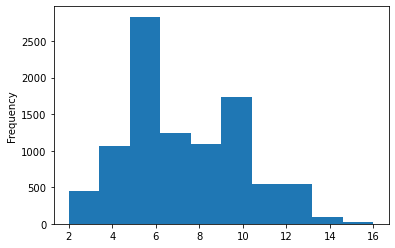

In [27]:
data['code'].str.len().plot.hist()

In [28]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

16

In [29]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 9632/9632 [00:00<00:00, 147681.79it/s]


In [30]:
data['code'].str.len().describe().astype(int)

count    9632
mean       16
std         0
min        16
25%        16
50%        16
75%        16
max        16
Name: code, dtype: int64

In [31]:
# data

## строим датасет

In [32]:
pair

,id_L,id_R,target
0,6153,6153,1
0,2827,6118,1
0,6143,6061,1
0,6164,18522,1
0,6118,6143,1
...,...,...,...
225,19453,2035,0
225,6033,13895,0
225,6036,13897,0
225,19456,13888,0


In [33]:
dataset = pair\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )
ppr(dataset)
dataset.sample(3)

записей: 4 520


,id_L,id_R,target,code_L,code_R
2713,983,11957,0,"[4928, 4105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5684, 7088, 9301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1664,8990,18149,1,"[1003, 4197, 6481, 5772, 3680, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1003, 5772, 1239, 7011, 700, 2029, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1507,5355,5349,1,"[8968, 5911, 633, 9466, 2416, 3113, 76, 8000, 0, 0, 0, 0, 0, 0, 0, 0]","[8968, 2057, 3902, 2515, 634, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [34]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((4520, 16), (4520, 16), (4520, 1))

In [35]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [36]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((4520, 16), (4520, 16), (4520, 1), 9976)

In [37]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [38]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

16

In [39]:
# from sklearn.model_selection import train_test_split
# from matplotlib import pyplot as plt

In [40]:
# # отделяем тестовый набор
# x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [41]:
# x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
# y_train = y_train.flatten()
# x_left_train.shape, x_right_train.shape, y_train.shape

In [42]:
# x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
# y_test = y_test.flatten()
# x_left_test.shape, x_right_test.shape, y_test.shape

In [43]:
# %xdel x_left
# %xdel x_right
# %xdel target

In [44]:
# gc.collect()

In [45]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [46]:
embed_len = 128
embed_input_dim, embed_len, seq_len

(9976, 128, 16)

In [47]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.4.0', '2.4.0')

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.losses import contrastive_loss
from tensorflow import cast

$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

In [49]:
def contrastive_loss(y, preds, margin=1):
    y = cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean( y * K.square(preds) + (1-y)*squaredMargin)

$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

In [50]:
# from matplotlib import pyplot as plt
# y = np.ones(10)
# p = np.linspace(0,1,10)
# # y = np.zeros(10)
# # p = np.linspace(1,0,10)
# plt.plot( y*(p**2) + (1-y)*((1-p)**2) )

In [51]:
embed_input_dim,seq_len,embed_len

(9976, 16, 128)

In [52]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

In [53]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

# классификатор
predictions = Dense(1, activation='relu')(merged)

# создаём модель
model = Model([input_l,input_r], predictions )

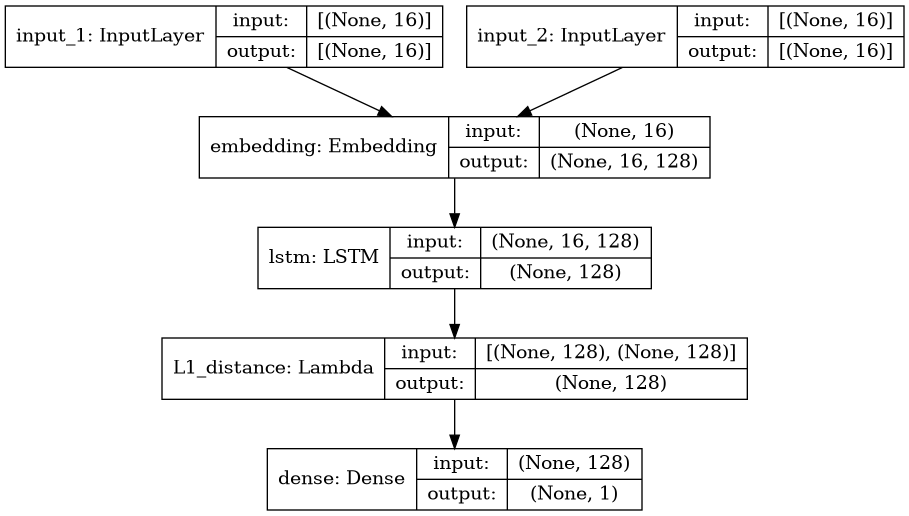

In [54]:
plot_model(model, show_layer_names=True, show_shapes=True )

In [55]:
learning_rate = 9e-3
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [56]:
x_left.shape,target.shape

((4520, 16), (4520, 1))

In [57]:
%%time

n_epochs = 25

history = model.fit( [x_left, x_right], target,epochs = n_epochs, batch_size = 1024, )

Epoch 1/25
5/5 [==============================] - 3s 40ms/step - loss: 0.4252 - acc: 0.4927
Epoch 2/25
5/5 [==============================] - 0s 38ms/step - loss: 0.2281 - acc: 0.3969
Epoch 3/25
5/5 [==============================] - 0s 39ms/step - loss: 0.1392 - acc: 0.1657
Epoch 4/25
5/5 [==============================] - 0s 41ms/step - loss: 0.0967 - acc: 0.1008
Epoch 5/25
5/5 [==============================] - 0s 38ms/step - loss: 0.0776 - acc: 0.0643
Epoch 6/25
5/5 [==============================] - 0s 39ms/step - loss: 0.0597 - acc: 0.0439
Epoch 7/25
5/5 [==============================] - 0s 36ms/step - loss: 0.0450 - acc: 0.0272
Epoch 8/25
5/5 [==============================] - 0s 38ms/step - loss: 0.0320 - acc: 0.0188
Epoch 9/25
5/5 [==============================] - 0s 39ms/step - loss: 0.0200 - acc: 0.0116
Epoch 10/25
5/5 [==============================] - 0s 41ms/step - loss: 0.0110 - acc: 0.0058
Epoch 11/25
5/5 [==============================] - 0s 40ms/step - loss: 0.0059 

----

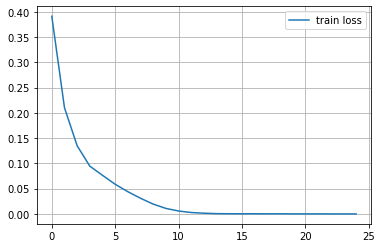

In [58]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

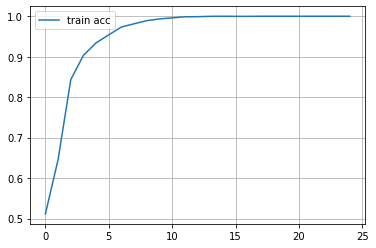

In [59]:
plt.plot( 1. - np.array(history.history['acc']), label='train acc')
# plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [60]:
# gc.collect()

## тест

In [61]:
# dataset.sample(2)

In [62]:
dataset['dist'] = model.predict([x_left,x_right,])

In [63]:
data_dist = dataset[['id_L','id_R','target','dist']]\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_R','Наименование':'ttext_R'}),on='id_R')\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_L','Наименование':'ttext_L'}),on='id_L')\
    [['ttext_L','ttext_R','dist']]

# data_dist.sample(3)

In [64]:
data_dist[['dist']].describe().T

,count,mean,std,min,25%,50%,75%,max
dist,4520.0,1.03963,1.137006,0.0,0.0,0.507592,1.974883,5.352191


In [65]:
# похожие тексты
data_dist[ (data_dist['dist']<0.5) & (data_dist['ttext_L']!=data_dist['ttext_R']) ].sample(10)

,ttext_L,ttext_R,dist
2274,Плитки огнеупорные из кремнеземистой каменной муки или диатомитовых земель,Изделия огнеупорные безобжиговые,0.0
4314,"Газогенераторы, аппараты для дистилляции и фильтрования","Оборудование для взвешивания и дозировки промышленное, бытовое и прочее",0.0
1139,Соли прочих ароматических монокарбоновых кислот,Эфиры линоленовой кислоты сложные,0.0
1719,Лом и отходы кадмия и его сплавов,Лом и отходы чугунные легированные,0.0
1979,Услуги федерального государственного метрологического надзора,Услуги по инженерно-техническому проектированию объектов водоснабжения и канализации,0.0
4428,Аккордеоны и аналогичные инструменты,Части и принадлежности духовых музыкальных инструментов,0.0
2874,"Услуги профессиональные, научные и технические, прочие, не включенные в другие группировки",Услуги по проведению оценки уязвимости объектов транспортной инфраструктуры и транспортных средств,0.0
390,"Овцы взрослые, кроме чистопородных племенных овец","Овцы взрослые тонкорунных пород, кроме чистопородных племенных овец",0.0
2778,"Светильники электрические настольные, прикроватные или напольные",Лампы накаливания или газоразрядные лампы; дуговые лампы; светодиодные лампы,0.0
2583,Услуги по розничной торговле животными маслами и жирами в специализированных магазинах,Услуги по розничной торговле молочными продуктами в специализированных магазинах,0.0


In [66]:
# НЕпохожие тексты
data_dist[ (data_dist['dist']>0.5) ].sample(10)

,ttext_L,ttext_R,dist
3643,"Смеси асфальтобетонные дорожные, аэродромные и асфальтобетон холодные","Услуги по техническим испытаниям и анализу прочие, не включенные в другие группировки",1.476404
1767,Крафт-бумага мешочная крепированная или гофрированная,Провода и кабели электронные и электрические прочие,1.541717
3563,Кузова для автотранспортных средств,Услуги государственного управления в бюджетно-финансовой и налоговой сфере,2.236825
3345,Угли активированные из торфяного сырья,Двигатели турбореактивные и турбовинтовые,1.588017
631,"Услуги, связанные с лесоводством, прочие, не включенные в другие группировки",Соки фруктово-овощные диффузионные восстановленные,1.537036
2841,Приборы полупроводниковые и их части,Услуги в области дополнительного образования вспомогательные,1.923834
3164,"Услуги, оказываемые младшим медицинским персоналом хирургических отделений больниц",Соли прочих ароматических монокарбоновых кислот,1.870764
4185,Машины и приборы для механизации кухонных работ,Трубопроводы магистральные наземные и подводные для перекачки нефтепродуктов и газа,1.874284
2278,Оборудование технологическое для крупяной промышленности,Пряжа хлопчатобумажная однониточная гребенная суровая для трикотажного производства,2.771484
1999,Услуги по покраске металлических корпусов будильников и крупногабаритных часов,Трубы и муфты асбестоцементные безнапорные,2.936411
